<a href="https://colab.research.google.com/github/swishswish123/tracked_surgery_simulations/blob/main/tracked_pointer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) TRACKED POINTER SIMULATION

The current state of the art for pituitary surgery uses a tracked pointer, registered to a pre-operative MR scan for orientation of surrounding anatomy. This notebook explores what the expected level of accuracy might be.

## imports and utility functions

In [37]:
# github repo which contains all the images
!git clone https://github.com/swishswish123/tracked_surgery_simulations.git repo

Cloning into 'repo'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), 266.24 KiB | 2.20 MiB/s, done.


In [38]:
# install necessary packages
!pip install scikit-surgerycore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
# importing packages
from IPython.display import Image
import numpy as np
import sksurgerycore.transforms.matrix as stm
import sksurgerycore.transforms.matrix as mu
import cv2

In [42]:
from tracked_surgery_simulations.utils import test_function

In [52]:

def extrinsic_vecs_to_matrix(array_of_parameters):
    """
    Returns a homogeneous rigid transformation as 4x4 np.ndarray.

    :param array_of_parameters: list of [tx, ty, tz, rx, ry, rz] where rotations are in degrees.
    """
    rotation = mu.construct_rotm_from_euler(array_of_parameters[3],
                                            array_of_parameters[4],
                                            array_of_parameters[5],
                                            sequence='xyz',
                                            is_in_radians=False)
    translation = np.zeros((3,1))
    translation[0][0] = array_of_parameters[0]
    translation[1][0] = array_of_parameters[1]
    translation[2][0] = array_of_parameters[2]

    transform = mu.construct_rigid_transformation(rotation, translation)
    return transform


def extrinsic_matrix_to_vecs(transformation_matrix):
    """
    Method to convert a [4x4] rigid body matrix to an rvec and tvec.
    :param transformation_matrix: [4x4] rigid body matrix.
    :return [3x1] Rodrigues rotation vec, [3x1] translation vec
    """
    rmat = transformation_matrix[0:3, 0:3]
    rvec = (cv2.Rodrigues(rmat))[0]
    tvec = np.ones((3, 1))
    tvec[0:3, 0] = transformation_matrix[0:3, 3]
    return rvec, tvec

In [44]:
def multiply_points_by_matrix(matrix_4x4, matrix_of_points, do_transpose):
    """
    Multiplies all points by the same matrix.

    :param matrix_4x4: Numpy ndarray, 4x4, containing homogenous, rigid transformation
    :param matrix_of_points: Numpy ndarray, 4xN, containing N points as 4D homogeneous column vectors.
    :param do_transpose: if true, we also transpose
    """
    input_matrix = matrix_of_points

    if do_transpose:
        input_matrix = np.transpose(matrix_of_points)

    result = np.matmul(matrix_4x4, input_matrix)

    if do_transpose:
        result = np.transpose(result)

    return result

def multiply_points_by_transform(D3_points, T):
    """
    Applies a 4x4 transformation matrix to a set of 3D points.

    Args:
        D3_points (numpy.ndarray): Array of 3D points with shape (N, 3).
        T (numpy.ndarray): 4x4 transformation matrix.

    Returns:
        (numpy.ndarray) Array of transformed 3D points with shape (N, 3).
    """
    D3_hom = cv2.convertPointsToHomogeneous(D3_points).squeeze()
    D3_transformed_points_hom = T @ D3_hom.T
    D3_transformed_points_hom = D3_transformed_points_hom.reshape(4, -1)
    D3_transformed = cv2.convertPointsFromHomogeneous(D3_transformed_points_hom.T).squeeze()

    return D3_transformed.reshape(-1,3)

## Background, System Layout, goal and assumptions

The following diagram shows the layout of the navigation system and the different components involved in the surgery when using a pointer. 

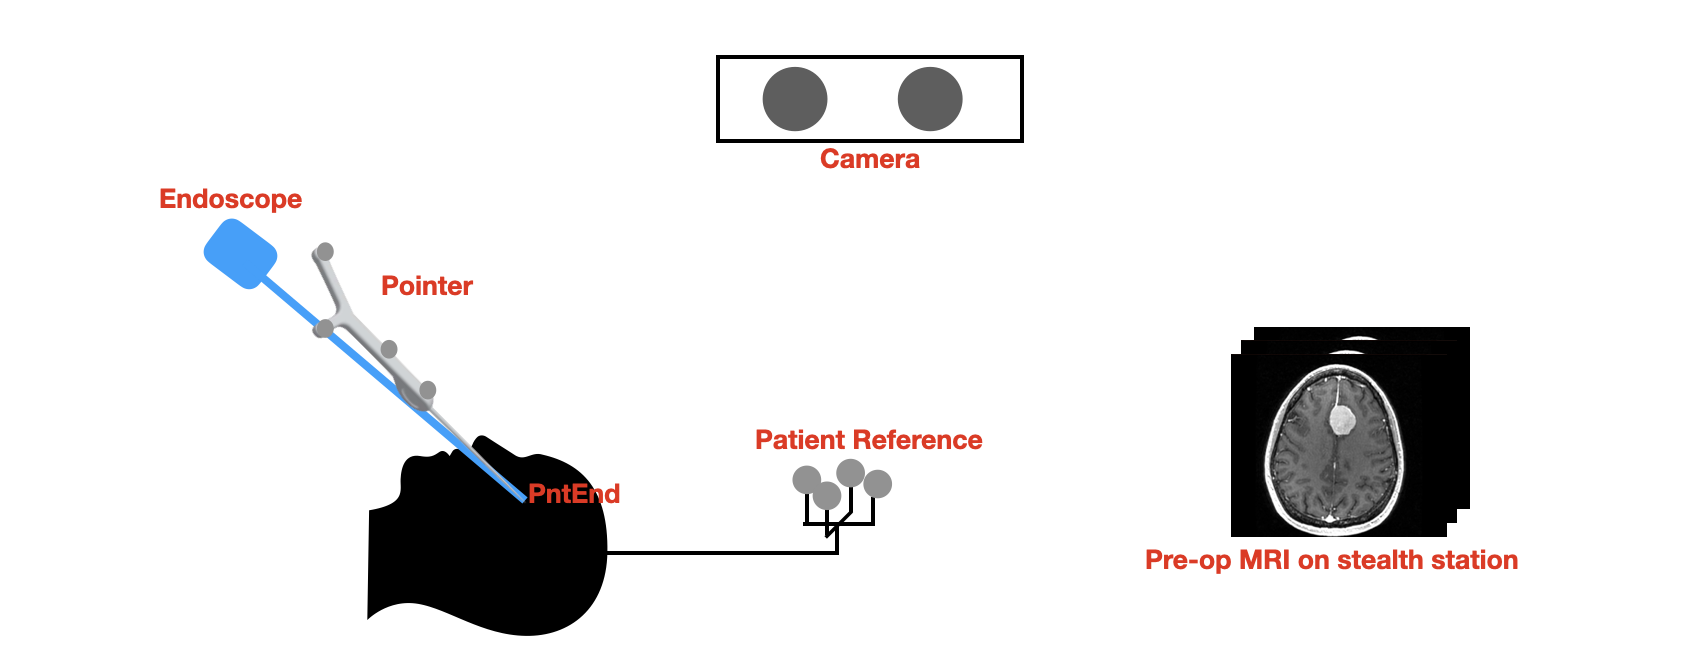

In [ ]:
Image(filename="./repo/assets/pointer_setup.png")



### A bit of maths background:
To convert between different coordinate systems, we can use a mathematical transform, defined as ${}^{B}T_{A}$. This maps a point from the coordinate system $A$ to the coordinate system $B$. 

${}^{B}T_{A}$ can be defined as a (4x4) matrix. Since we assume the transformations to be rigid, this matrix can only be composed of rotations and translations.

${}^{B}T_{A} = 
\begin{bmatrix}
R & T \\
0 & 1
\end{bmatrix}$

Where R is a (3x3) sub-matrix of ${}^{B}T_{A}$, represents the rotation component of the transform. It defines how the axes of the $A$ coordinate system should be rotated to align with the axes of the $B$ coordinate system. The translation component, denoted as $T$ (3x1), represents the offset between the origins of the $A$ and $B$ coordinate systems.

Now by applying ${}^{B}T_{A}$ to a point in the $A$ coordinate system, we can transform the point to its corresponding position in the $B$ coordinate system. 

### Combining transforms
Different transforms can be combined to create a transform from one coordinate system to another. Suppose we have three coordinate systems, $A$, $B$, and $C$. We have transformations ${}^{B}T_{A}$ which map points from coordinate system $A$ to $B$ and ${}^{C}T_{B}$ which maps from $B$ to $C$. We can use these transformations to create a transform ${}^{C}T_{A}$, which maps points from coordinate system $A$ to $C$. This composed transform can be obtained by simply multiplying the other two in the correct order:

${}^{C}T_{A}$ = ${}^{C}T_{B}$ · ${}^{B}T_{A}$

Note that the combination starts on the right and ends on the left- we start at coordinate system $A$ and convert it to $B$ with ${}^{B}T_{A}$ on the right and then we move towards the left converting $B$ to $C$- ${}^{C}T_{B}$.

${}^{C}T_{A}$ can now be used to convert any point from coordinate system $A$ to coordinate system $C$.



### Goal

Going back to our problem, the goal is to be able to match the coordinate system of the pointer's tip to the MRI so that wherever we put the pointer's tip, this location can be displayed on the MRI.

What we want to achieve is obtain a transform
from the pointer's tip to the MRI coordinate system.

X<sub>MRI</sub> = T X<sub>PntTip</sub>

We cannot obtain a direct transformation with our setup, but we can build this transformation out of the following transformations:

T = <sup>MRI</sup>T<sub>PatRef</sub> * 
    <sup>PatRef</sup>T<sub>Cam</sub>  * 
    <sup>Cam</sup>T<sub>PntRef</sub> * 
    <sup>PntRef</sup>T<sub>PntTip</sub>

Note on notation used:
As in the diagram, Pnt stands for pointer, Ref stands for reference, Cam stands for the infrared camera and Pat stands for patient. 

In the following sections we will go step by step composing these transforms and finally using them to transform a point from pointer tip (PntTip) coordinates to MRI coordinates.

Below is a visual representation of the pointer setup with all the transforms:


In [ ]:
Image(filename="./repo/assets/pointer_setup_transforms.png")

### Assumptions

1. tumour, patient reference, pointer reference are all aligned in z direction (have same z coordinate) and are facing the camera straight on so that the distance is $D$.

2. Patient reference is at a set distance $Y_t$ from the tumour but aligned in the X direction.

3. Pointer is touching the tumour, so the pointer and tumour have the same coordinates.

4. Length of pointer is known ($P$)

5. Angle of pointer is known ($𝜃$)

6. All transformations assumed to be rigid

Below is a visual representation of the sagittal and transverse views with all assumptions.


In [ ]:
Image(filename="./repo/assets/pointer_setup_assumptions.png")

In [45]:
# Assumptions- configurable parameters

# ALL MEASUREMENTS IN MM

# P - length from tip of pointer to reference of pointer
POINTER_LENGTH = 140  # reference NDI

# D - z distance from camera to plane where everything is located
DISTANCE_FROM_CAM = 2000  # since the camera and patient reference are aligned in the x and y directions, only distance is in z

# 𝜃 - angle of pointer
POINTER_ANGLE = 45

# Yt - distances from tumour to patient reference
TUMOUR_PARTEF = 300

# NDI quotes 0.25mm for Polaris Spectra, some papers estimate it at 0.17mm
# TYPICAL_TRACKING_SIGMA = 0.25

# for simulation reproducibility
NUMBER_SAMPLES = 9000

# for sufrace registration initial misalignment
X_T = 100  # head length (about 20cm)
Y_T = 130  # menton to top of head (about 25cm)
Z_T = 80  # head bredth (about 15cm)

END_SIGMA = 0.5
SIGMA_STEP = 0.01


## Defining some functions

In order to obtain the transforms, we also need to define the reference of the different coordinate systems.

A reference is essentially a unique grouping of reflective markers, attached to a tool which defines a local coordinate system. The markers' location can be determined as they are reflective and therefore the infrared camera can locate them in space at any given point if they are within the camera's working range.

Below you can see the reference systems used for the patient and the pointer:

In [ ]:
# pointer reference
Image('./repo/assets/pointref_geometry.png')


In [ ]:
# patient reference
Image('./repo/assets/pattref_geometry.png')


In [46]:

def create_pat_ref():
    """
    Create reference coordinates of a marker pattern in a numpy matrix.

    This function creates a numpy matrix containing the reference coordinates of a marker pattern used for
    pose estimation. The marker pattern consists of four markers labeled A, B, C and D. The reference coordinates
    of each marker point are defined in a right-handed reference frame as follows:

        Marker A: (0, 0, 0)
        Marker B: (41.02, 0, 28.59)
        Marker C: (88.00, 0, 0)
        Marker D: (40.45, 0, -44.32)

    The function returns a 4x4 numpy matrix containing the homogenous coordinates of each marker point, with the
    last element of each row set to 1.

    Returns:
        numpy.ndarray: A 4x4 numpy matrix containing reference coordinates of a marker pattern. Each row represents a
        marker point in homogenous coordinates.
    """

    # Encoding the reference marker points into a numpy matrix
    pat_ref = np.zeros((4, 4))
    # marker A (0) -> (0,0,0)

    # marker B (1) -> (41.02 ,0,28.59)
    pat_ref[1][0] = 41.02  # x
    pat_ref[1][2] = 28.59  # z

    # marker C (2) -> C = (88.00 ,0, 0)
    pat_ref[2][0] = 88  # x

    # marker D (3) -> (40.45,0,-44.32)
    pat_ref[3][0] = 40.45  # x
    pat_ref[3][2] = -44.32  # z

    # adding 1 to last row to make coordinates homogenous
    pat_ref[0][3] = 1.0
    pat_ref[1][3] = 1.0
    pat_ref[2][3] = 1.0
    pat_ref[3][3] = 1.0
    return pat_ref


def create_pnt_ref():
    """
    Creates a numpy matrix representing the pointer reference coordinates.

    Returns:
    pnt_ref (numpy matrix): A 4x4 numpy matrix containing the pointer reference coordinates
                            as row vectors in homogenous coordinates. The four rows represent
                            the markers A, B, C, and D in that order.
    """
    # Creating pointer reference (from datasheet). Using homogenous (4 numbers, x,y,z,1) as row vectors.
    pnt_ref = np.zeros((4, 4))

    # marker A (0) -> 0,0,0

    # marker B (1) -> 0,50,0
    pnt_ref[1][1] = 50  # y

    # marker c (2) -> 25,100,0
    pnt_ref[2][0] = 25  # x
    pnt_ref[2][1] = 100  # y

    # marker d (3) -> -25, 135, 0
    pnt_ref[3][0] = -25  # x
    pnt_ref[3][1] = 135  # y

    # adding 1 to 3rd dimension to turn to homogeneous coordinates
    pnt_ref[0][3] = 1
    pnt_ref[1][3] = 1
    pnt_ref[2][3] = 1
    pnt_ref[3][3] = 1

    return pnt_ref



# Obtaining transforms

Sine we are assuming the layout and relative positions of each reference marker, we are able to obtain the transformations between each coordinate system.

In [47]:
def get_transforms(pointer_length=100):
    """
    Returns a set of coordinate transformation matrices that convert points from one reference frame to another.

    Args:
        pointer_length (float): Length of the pointer in millimeters. Default is 100.

    Returns:
        tuple: A tuple containing the following eight transformation matrices:
        - Cam_T_PatRef: A 4x4 transformation matrix that converts points from the patient reference frame to the camera reference frame.
        - Cam_T_PntRef: A 4x4 transformation matrix that converts points from the pointer reference frame to the camera reference frame.
        - PntRef_T_PntTip: A 4x4 transformation matrix that converts points from the pointer tip reference frame to the pointer reference frame.
        - PatRef_T_MRI: A 4x4 transformation matrix that converts points from the MRI reference frame to the patient reference frame.

        and the following numpy arrays containing the homogenous coordinates of the points in the given reference frame
        - pnt_ref_marker:  in the pointer reference frame.
        - pnt_ref_cam: in the camera reference frame.
        - pat_ref_marker: in the patient reference frame.
        - pat_ref_cam: in the camera reference frame.

    """

    print(f'pointer length: {pointer_length}')
    # Creating a marker in the pointer reference frame.
    pnt_ref_marker = create_pnt_ref()  # marker coords

    # Point tip to point reference (pointer length translation in -y)
    PntRef_T_PntTip = extrinsic_vecs_to_matrix(
        [0, -pointer_length, 0, 0, 0, 0])  # create transform of all points depending on pointer's length
    pnt_ref_tip = multiply_points_by_matrix(np.linalg.inv(PntRef_T_PntTip), pnt_ref_marker,
                                            do_transpose=True)  # transform all pointer ref points to pointer tip

    # Converting the marker points to the camera reference frame by applying a
    # rotation of POINTER_ANGLE degrees about the z-axis followed by a
    # translation of DISTANCE_FROM_CAM along the z-axis.
    rotate_about_z = extrinsic_vecs_to_matrix([0, 0, 0, 0, 0, POINTER_ANGLE])
    translate_away_from_camera = extrinsic_vecs_to_matrix([0, 0, DISTANCE_FROM_CAM, 0, 0, 0])
    Cam_T_PntRef = translate_away_from_camera @ rotate_about_z
    pnt_ref_cam = multiply_points_by_matrix(Cam_T_PntRef, pnt_ref_marker, do_transpose=True)

    # PatRef to Cam (add dist to cam to z plus x translation to right)
    pat_ref_marker = create_pat_ref()
    # translating to correct location 
    translate_along_x = extrinsic_vecs_to_matrix([TUMOUR_PARTEF, 0, 0, 0, 0, 0])
    Cam_T_PatRef = translate_along_x @ translate_away_from_camera
    pat_ref_cam = multiply_points_by_matrix(Cam_T_PatRef, pat_ref_marker, do_transpose=True)

    PatRef_T_MRI = extrinsic_vecs_to_matrix([X_T, Y_T, Z_T, 0, 0, 0])

    return Cam_T_PatRef, Cam_T_PntRef, PntRef_T_PntTip, PatRef_T_MRI, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam


In [49]:
Cam_T_PatRef, Cam_T_PntRef, PntRef_T_PntTip, PatRef_T_MRI, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam = get_transforms(pointer_length=100)

pointer length: 100


In [51]:
print('Cam_T_PatRef')
print(Cam_T_PatRef)

print('Cam_T_PntRef')
print(Cam_T_PntRef)

print('PntRef_T_PntTip')
print(PntRef_T_PntTip)

print('PatRef_T_MRI')
print(PatRef_T_MRI)

print('pnt_ref_marker')
print(pnt_ref_marker)

print('pnt_ref_cam')
print(pnt_ref_cam)

print('pat_ref_marker')
print(pat_ref_marker)

print('pat_ref_cam')
print(pat_ref_cam)

Cam_T_PatRef
[[1.e+00 0.e+00 0.e+00 3.e+02]
 [0.e+00 1.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+00 2.e+03]
 [0.e+00 0.e+00 0.e+00 1.e+00]]
Cam_T_PntRef
[[ 7.07106781e-01 -7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 7.07106781e-01  7.07106781e-01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.00000000e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
PntRef_T_PntTip
[[   1.    0.    0.    0.]
 [   0.    1.    0. -100.]
 [   0.    0.    1.    0.]
 [   0.    0.    0.    1.]]
PatRef_T_MRI
[[  1.   0.   0. 100.]
 [  0.   1.   0. 130.]
 [  0.   0.   1.  80.]
 [  0.   0.   0.   1.]]
pnt_ref_marker
[[  0.   0.   0.   1.]
 [  0.  50.   0.   1.]
 [ 25. 100.   0.   1.]
 [-25. 135.   0.   1.]]
pnt_ref_cam
[[ 0.00000000e+00  0.00000000e+00  2.00000000e+03  1.00000000e+00]
 [-3.53553391e+01  3.53553391e+01  2.00000000e+03  1.00000000e+00]
 [-5.30330086e+01  8.83883476e+01  2.00000000e+03  1.00000000e+00]
 [-1.13137085e+02  7.7781745

In [ ]:
Cam_T_PatRef, Cam_T_PntRef, PntRef_T_PntTip, PatRef_T_MRI, pnt_ref_marker, pnt_ref_cam, pat_ref_marker, pat_ref_cam = get_transforms(pointer_length=100)